# Quantum Circuit Learning Demo
After downloading Forest SDK 1.8+, run the following cells to perform the QCL Overfit test

In [1]:
import pennylane as qml
from pennylane import numpy as np
import pennylane.optimize

In [2]:
import os
import time
import random
import pickle
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchsummary import summary

In [3]:
from tqdm import tqdm
from MNISTData import MNISTData
from AutoEncoder import AutoEncoder

In [4]:
ENCODING_SIZE = 10 # dimension of the encoded input
NUM_QUBITS =4 # number of qubit wires we're using
NUM_CLASSES= 10 # number of output classes
NUM_LAYERS = 10 # number of entangle->rotate layers deep a given circuit should be.

In [5]:
dev = qml.device("forest.qvm", device="{}q-pyqvm".format(NUM_QUBITS), shots=1000)
device = torch.device('cpu') # This demo does not support CUDA

In [6]:
from pennylane.ops import RX, RY, CNOT

#params: x - input x
#        thetas - learned parameters, in shape (NUM_LAYERS, 2*NUM_QUBITS)
#NOTE: Written for NUM_QUBITS = 4
@qml.qnode(dev, interface='torch')
def circuit(x, thetas):
    # Lay input values over the four wires
    for i in range(ENCODING_SIZE):
            if i // NUM_QUBITS % 2 == 0: 
                RX(x[i], wires=i//NUM_QUBITS)
            else:
                RY(x[i], wires=i//NUM_QUBITS)
    for j in range(NUM_LAYERS):
        # Entangle the wires
        CNOT(wires=[0, 1])
        CNOT(wires=[1, 3])
        CNOT(wires=[0, 2])
        # Perform rotations
        for i in range(NUM_QUBITS):
            RX(thetas[j][i], wires=i)
        for i in range(NUM_QUBITS, 2 * NUM_QUBITS):
            RY(thetas[j][i], wires=(i - NUM_QUBITS))
    return [qml.expval.PauliZ(wires=i) for i in range(NUM_QUBITS)]

At this point, we have to get our (encoded) images so that we may actually start training

In [7]:
data = MNISTData(batch_size=16)
train_loader = data.get_train_loader()
test_loader = data.get_test_loader()

In [8]:
load_from_stem = "./autoencoder_models/1558731906/"
load_model_from = os.path.join(load_from_stem, "ae.pt")
load_layers_from = os.path.join(load_from_stem, "layer_sizes.pkl")

In [9]:
with open(load_layers_from, 'rb') as f:
    layer_sizes = pickle.load(f)
layer_sizes = layer_sizes[1:]
ae = AutoEncoder(layer_sizes)
ae.load_state_dict(torch.load(load_model_from))
encoder = ae.encoder
#encoder.to(torch.device('cpu'))
for child in encoder.children():
    for param in child.parameters():
        param.to(device)
        param.requires_grad = False

In [11]:
thetas = 1/ENCODING_SIZE*np.random.randn(2 * NUM_QUBITS*NUM_LAYERS*NUM_CLASSES)
bias = np.zeros(NUM_CLASSES)
thetas = thetas.reshape(NUM_CLASSES, NUM_LAYERS, 2*NUM_QUBITS)
thetas = Variable(torch.tensor(thetas, device='cpu'),requires_grad=True)
bias = Variable(torch.tensor(bias, device='cpu'),requires_grad=True)

In [12]:
# this is the transformation that you need to do in order
# to pass it to the encoder. view is (1, -1) since the first number
# is the number of channels, which in our case is 1
enums = enumerate(train_loader, 1)
i, data = next(enums)
inputs, labels = data
print(inputs.size())
print(len(labels))
print(encoder(inputs[0].view(1, -1)))
print(encoder(inputs[0].view(1, -1)).size())
print(circuit(encoder(inputs[0].view(-1)), thetas[0]))

torch.Size([16, 1, 28, 28])
16
tensor([[32.3574, 38.5698,  0.0000, 11.4904,  6.5081, 12.7113, 18.0151, 16.4128,
         13.4374,  0.0000]])
torch.Size([1, 10])
tensor([ 0.5100, -0.8280,  0.5440,  0.4560], dtype=torch.float64,
       grad_fn=<_TorchQNodeBackward>)


In [13]:
def accuracy(thetas, bias, number_batches=2):
    with torch.no_grad():
        correct = 0
        total = 0
        for i, data in enumerate(test_loader, 0):
            if i == number_batches:
                break
            inputs, labels = data
            inputs = encoder(inputs.view(len(labels), -1)).numpy()
            predicted = []
            for image in inputs:
                scores = []
                for i in range(NUM_CLASSES):
                    scores.append(torch.mean(circuit(image, thetas[i]) + bias[i]))
                predicted.append(np.argmax(scores))
            correct += (np.asarray(predicted) == labels.numpy()).sum()
            total += len(predicted)
            print(predicted)
        return(correct / total)
# have done no training, so should be around 10%
accuracy(thetas, bias)

[0, 4, 4, 7, 4, 8, 9, 4, 1, 7, 4, 8, 9, 9, 7, 3]
[9, 4, 3, 3, 7, 8, 4, 4, 9, 9, 9, 3, 3, 4, 8, 0]


0.125

In [15]:
# Overfit like crazy on the first 16 examples
# ~Five minutes a batch, on our hardware
overfit = []
for i, data in enumerate(train_loader, 0):
    overfit.append((i, data))
    if i == 0:
        break

## Quantum Training Loop
Runs 30 epochs over our single overfit batch. Peforms Adam optimization, using analytically computed gradients for quantum gate parameters using Pennylane.

In [16]:
etas = [1e-2] # We use a learning rate of 1e-2
start = time.time()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([thetas, bias], lr=.01) # Adam interfaces with PennyLane
losses_quantum = []
for eta in etas:
    for epoch in range(30):
        running_loss = 0.0
        for i, data in overfit:
            inputs, labels = data
            optimizer.zero_grad()
            X = encoder(inputs.view(len(labels), -1))
            outputs = torch.zeros([len(X), NUM_CLASSES], dtype=torch.double)
            for i in range(len(X)):
                for j in range(NUM_CLASSES):
                    outputs[i, j] += torch.mean(circuit(X[i], thetas[j]) + bias[j])
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(running_loss)
        losses_quantum.append(running_loss)

2.3154754269232494
2.2702907867326236
2.2256062961631167
2.1846586345576173
2.1411301106387066
2.106572814066159
2.0737310818860757
2.03370474048498
2.0053961200780526
1.9743431188258553
1.9476842063585524
1.924069972380033
1.9010586444904576
1.8719913084298685
1.8548800076158658
1.8345343750811365
1.8229037135193633
1.8022137318877156
1.792869520685005
1.7844130554231203
1.7652688926020763
1.7528248828801527
1.740569509235792
1.732718129423903
1.7215459806070386
1.7135498906566624
1.7039735068145028
1.6956386154341108
1.6846191598624534
1.6744907949744958


In [20]:
# Peek at our train accuracy after all 30 epochs.
# Should be close to .625
with torch.no_grad():
    for i, data in overfit:
        inputs, labels = data
        inputs = encoder(inputs.view(len(labels), -1)).numpy()
        predicted = []
        correct = 0
        total = 0
        for image in inputs:
            scores = []
            for i in range(NUM_CLASSES):
                scores.append(torch.mean(circuit(image, thetas[i]) + bias[i]))
            predicted.append(np.argmax(scores))
        correct += (np.asarray(predicted) == labels.numpy()).sum()
        total += len(predicted)
        print(labels)
        print(predicted)
        print(correct/total)

tensor([7, 7, 2, 6, 1, 7, 2, 6, 8, 5, 4, 1, 8, 4, 9, 6])
[6, 7, 2, 6, 1, 7, 2, 6, 8, 6, 4, 4, 6, 6, 7, 6]
0.625


In [30]:
# Overfit a linear model with same number of parameters.
# Could be anywhere from .5 to 1.00, depending on initialization
# and distribution of the minibatch
etas = [1e-2]
start = time.time()
recoder = nn.Sequential(nn.Linear(10, 40), nn.ReLU(), nn.Linear(40, 10))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(recoder.parameters(), lr=.01)
losses_linear = []
for eta in etas:
    for epoch in range(30):
        running_loss = 0.0
        for i, data in overfit:
            inputs, labels = data
            optimizer.zero_grad()
            X = encoder(inputs.view(len(labels), -1))
            outputs = recoder(X)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 8 == 7:
                print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 8))
                running_loss = 0.0
        print(running_loss)
        losses_linear.append(running_loss)

for i, data in overfit:
    inputs, labels = data
    X = encoder(inputs.view(len(labels), -1))
    outputs = recoder(X)
    print(labels)
    guesses = np.argmax(outputs.detach().numpy(), axis=1)
    counter = 0
    for i in range(len(guesses)):
        if labels[i] == guesses[i]:
            counter += 1
    print(counter/16)

8.854576110839844
3.1504855155944824
3.17079496383667
3.261718511581421
1.9136929512023926
1.6666462421417236
1.850232481956482
1.2173595428466797
1.1350982189178467
1.127807855606079
1.2135506868362427
1.0453777313232422
1.081648349761963
0.9248653650283813
0.9037123322486877
0.8197648525238037
0.7846201062202454
0.7168394327163696
0.6777791380882263
0.6341490745544434
0.6012409925460815
0.5734260678291321
0.5500508546829224
0.5293170213699341
0.5123202800750732
0.4950133264064789
0.47952258586883545
0.46547818183898926
0.4522339701652527
0.440244197845459
tensor([7, 7, 2, 6, 1, 7, 2, 6, 8, 5, 4, 1, 8, 4, 9, 6])
1.0


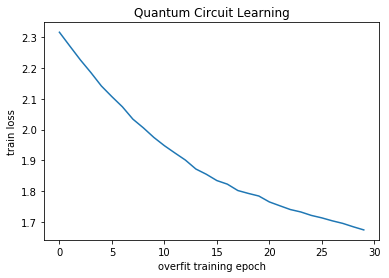

In [34]:
plt.plot(losses_quantum)
plt.ylabel('train loss')
plt.xlabel('overfit training epoch')
plt.title('Quantum Circuit Learning')
plt.show()

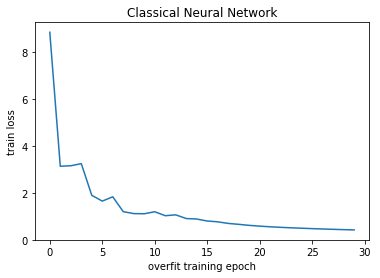

In [35]:
plt.plot(losses_linear)
plt.ylabel('train loss')
plt.xlabel('overfit training epoch')
plt.title('Classical Neural Network')
plt.show()